In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 5 Off-the-shelf Visualizations

### Setup

Load in each data file:

In [2]:
data = np.loadtxt('data/data.txt', skiprows=0, delimiter='\t', dtype='int')
test = np.loadtxt('data/test.txt', skiprows=0, delimiter='\t', dtype='int')
train = np.loadtxt('data/train.txt', skiprows=0, delimiter='\t', dtype='int')
movies = np.loadtxt('data/movies.txt', skiprows=0, delimiter='\t', dtype='str')

Read in the data, and put ratings in a list

In [3]:
totalRatings = {}
for element in data:
    if element[1] in totalRatings:
        totalRatings[element[1]] += 1
    else:
        totalRatings[element[1]] = 1

Now get the avg ratings

In [4]:
ratingList = []

for item in totalRatings.items():
    ratingList.append(item)
    
ratingList.sort(key=lambda x: x[1], reverse=True)

In [5]:
avgRatings = {}
for element in data:
    if element[1] in avgRatings:
        avgRatings[element[1]][0] += int(element[2])
        avgRatings[element[1]][1] += 1
    else:
        avgRatings[element[1]] = [int(element[2]), 1]

        
avgRatingList = []

for key, value in avgRatings.items():
    avgRatingList.append((key, value[0] / float(value[1])))
    
avgRatingList.sort(key=lambda x: x[1], reverse=True)

In [6]:
def get_err(U, V, Y, reg=0.1):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    
    # Sum of the squared loss
    summation = 0
    for element in Y:
        i = element[0]
        j = element[1]
        Y_ij = element[2]
        summation += ((Y_ij - np.dot(U[i - 1], V[j - 1])) ** 2)
    
    # Norm squared U 
    fro_U = 0
    for x in range(len(U)):
        for y in range(len(U[0])):
            fro_U += (U[x][y] ** 2)

    # Norm squared V 
    fro_V = 0
    for x in range(len(V)):
        for y in range(len(V[0])):
            fro_V += (V[x][y] ** 2)
    
    # Divide by the length of Y since its mean squared error
    return ((reg / 2) * (fro_U + fro_V) + 0.5 * summation) / len(Y)

## 5 Matrix Factorization Visualizations For Off-the-shelf Implementation

Using an Off-the-Shelf Implementation from the Surprise library, train using the surprise implementation of matrix factorization. The class surprise.prediction_algorithms.matrix_factorization.SVD() in Surprise does matrix factorization-based SVD algorithm. We will set the regularization parameter to 0.1, as that performed well in the matrix factorization we implemented in our original code from Set 5. We will not use a biased implementation of Surprise SVD. We will use 0.005 for the learning rate as it is small enough for gradient descent to approach a global minimum but large enough that it doesn't take too many epoches to converge. These parameters should all be specified in the initialization of the model.

In [7]:
# Import all libraries and dependencies.
import surprise
import os
import pandas as pd
from surprise.model_selection import KFold
from surprise import accuracy
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

We will use a regularization parameter of $\lambda=0.1$ since this performed best on the test set in the homework. 

First, run matrix factorization to get values of U and V and fit the model. In the surprise library, we have to train on the entire dataset, otherwise, it will result in truncation of some of the movies, because not all movies will be included in the test dataset. Thus, we train the surprise SVD model with the entire dataset and use the entire dataset for the training error, but we will calculate the testing error on the testset randomly selected from within the entire dataset. This is not ideal, but necessary to prevent loss and shrinkage of data.

In [8]:
# Create a pandas dataframe to hold the data in order to load it into the scikit-learn SVD.
ratings_dict = {'user': data[:, 0],
                'movie': data[:, 1],
                'rating': data[:, 2]}
df = pd.DataFrame(ratings_dict)

# A reader is needed to read the pandas dataframe.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
dataset = Dataset.load_from_df(df[['user', 'movie', 'rating']], reader)

# Initialize model.
algo = surprise.prediction_algorithms.matrix_factorization.SVD(n_factors = 20, biased = False, lr_all = 0.005, reg_all = 0.1)

# Fit the model on the entire dataset.
algo.fit(dataset.build_full_trainset())

Now, print the train and test errors:

In [36]:
# Get U and V from surprise model.
P = algo.pu
Q = algo.qi

U = np.array(P)
V = np.array(Q)

print("train error: " + str(get_err(U, V, data, reg=0.0)))
print("test error: " + str(get_err(U, V, test, reg=0.0)))

train error: 0.949926823277
test error: 0.942120472017


The training error and testing error are both approximately 0.94. 0.94 may seem like a high error, but this is actually not bad for the the matrix factorization of this dataset. It is noted in Surprise documentation and other implementations of matrix factorization, a neighborhood algorithm and more complex matrix factorization models also only achieve errors in the ballpark of 0.95, which is around where our training and testing errors are. 

We will print out the results of the Surprise model for the predicted M x N data. The M x N predicted matrix is below. After comparing these results to the predicted ones from the original MF we did in Set 5, the results are relatively similar. Comparing these results to the actual training set values, the results match the dataset fairly decently.

In [35]:
# Make prediction just to see resulting ratings.
surprise_pred = np.dot(U, V.transpose())
print(surprise_pred)

[[ 3.86736075  4.02929414  2.06652367 ...,  0.82695475  0.91556336
   1.00465999]
 [ 3.72659376  3.93236691  2.14534732 ...,  0.81196346  0.80054612
   1.02549594]
 [ 3.95077942  4.21846774  2.11057451 ...,  0.90590114  0.91677963
   1.11395504]
 ..., 
 [ 3.23579428  3.29437751  1.67386321 ...,  0.661866    0.71748308
   0.82929259]
 [ 3.46535699  3.69079954  1.90891622 ...,  0.78694098  0.82693663
   0.97304183]
 [ 4.2851817   4.50140145  2.28806154 ...,  0.89755365  1.01870514
   1.15403337]]


## Our visualizations for this part are included below:
## A) Ten movies of your choice from the MovieLens dataset

For the ten movies, we choose Star Wars (1977) (index 50), Stand by Me (1986) (index 655), Naked (1993) (index 960), Toy Story (1995) (index 1), It's a Wonderful Life (1946) (index 491), Pulp Fiction (1994) (index 56), "Shawshank Redemption, The (1994)" (index 64), Forrest Gump (1994) (index 69), Hercules (1997) (index 993), Titanic (1997) (index 313)

For each one of these movies, pull out the corresponding values from the $V_{tilda}$ matrix

Get the U_tilda and V_tilda needed for visualizing the data on a 2D space.
In order to visualize the resulting latent factors, apply SVD to V = AΣB and use the first two columns
of A to project U, V into a two-dimensional space. 

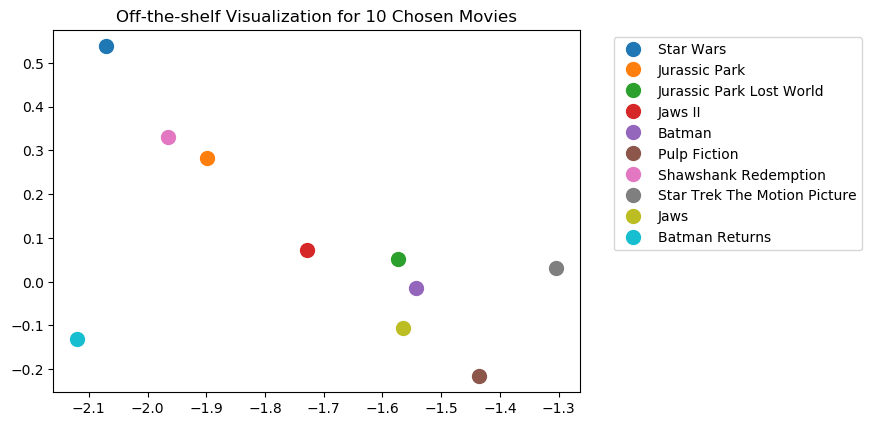

In [10]:
# Get U and V from surprise model.
P = algo.pu
Q = algo.qi

U = P
V = Q.transpose()

# Make prediction just to see resulting ratings.
surprise_pred = np.dot(U, V)

# Do SVD on V and U
u1, s1, v1 = np.linalg.svd(U, full_matrices = False)
u2, s2, v2 = np.linalg.svd(V, full_matrices = False)

two_columns_U = np.array(u1[:, :2])
two_columns_V = np.array(u2[:, :2])

# Compute U_tilda and V_tilda
U_tilda = np.dot(two_columns_U.transpose(), U)
V_tilda = np.dot(two_columns_V.transpose(), V)

U_tilda = np.array(U_tilda)
V_tilda = np.array(V_tilda)


plt.figure(num=None, figsize=(6.8, 4.8), dpi=100, facecolor='w', edgecolor='k')
plt.plot([V_tilda[0][49]], [V_tilda[1][49]], 'o', markersize=10, label='Star Wars')
plt.plot([V_tilda[0][81]], [V_tilda[1][81]], 'o', markersize=10, label='Jurassic Park')
plt.plot([V_tilda[0][251]], [V_tilda[1][251]], 'o', markersize=10, \
         label='Jurassic Park Lost World')
plt.plot([V_tilda[0][451]], [V_tilda[1][451]], 'o', markersize=10, label='Jaws II')
plt.plot([V_tilda[0][402]], [V_tilda[1][402]], 'o', markersize=10, \
         label='Batman')
plt.plot([V_tilda[0][55]], [V_tilda[1][55]], 'o', markersize=10, label='Pulp Fiction')
plt.plot([V_tilda[0][63]], [V_tilda[1][63]], 'o', markersize=10, \
         label='Shawshank Redemption')
plt.plot([V_tilda[0][448]], [V_tilda[1][448]], 'o', markersize=10, label='Star Trek \
The Motion Picture')
plt.plot([V_tilda[0][233]], [V_tilda[1][233]], 'o', markersize=10, label='Jaws')
plt.plot([V_tilda[0][230]], [V_tilda[1][230]], 'o', markersize=10, label='Batman Returns')

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title('Off-the-shelf Visualization for 10 Chosen Movies')
plt.figure(num=None, figsize=(6.8, 4.8), dpi=100, facecolor='w', edgecolor='k')
plt.show()
plt.savefig('graph1.png')

## B) The ten most popular movies (movies which have received the most ratings).

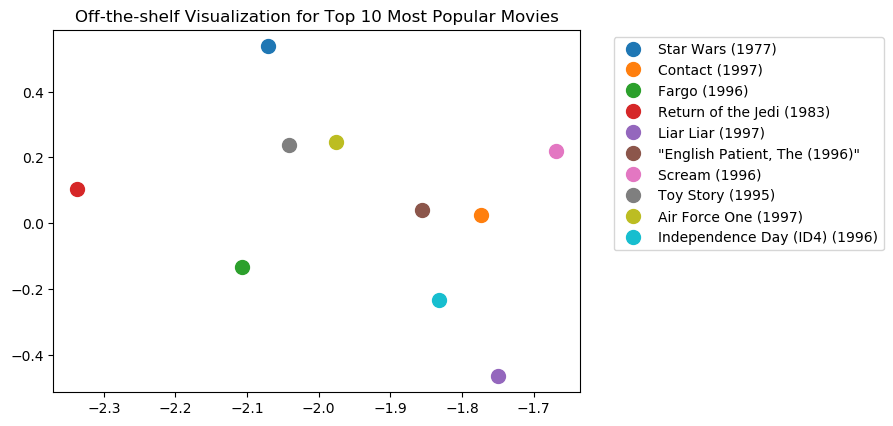

In [12]:
plt.figure(num=None, figsize=(6.8, 4.8), dpi=100, facecolor='w', edgecolor='k')
for element in ratingList[:10]:
    index = element[0]
    label = movies[index - 1][1]
    plt.plot([V_tilda[0][index - 1]], \
             [V_tilda[1][index - 1]], 'o', markersize=10, label=label)

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title('Off-the-shelf Visualization for Top 10 Most Popular Movies')
plt.show()

## C) The ten best movies (movies with the highest average ratings).

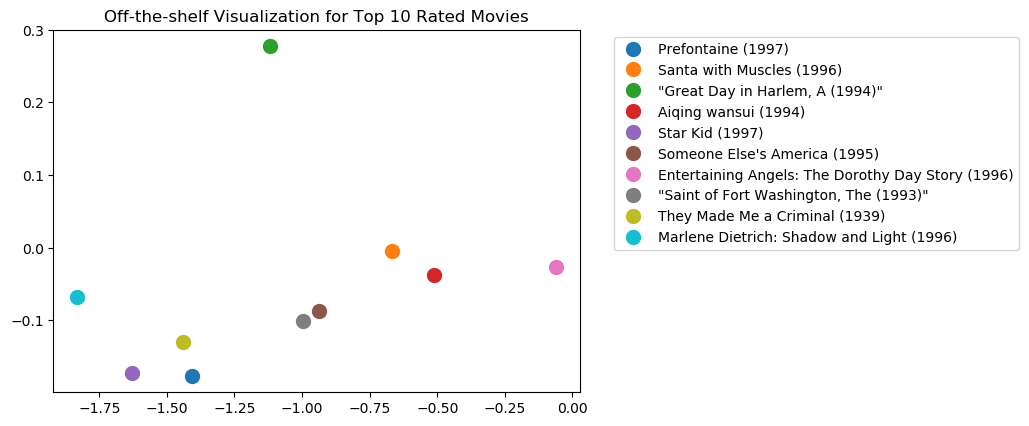

In [13]:
plt.figure(num=None, figsize=(6.8, 4.8), dpi=100, facecolor='w', edgecolor='k')
for element in avgRatingList[:10]:
    index = element[0]
    label = movies[index - 1][1]
    plt.plot([V_tilda[0][index - 1]], \
             [V_tilda[1][index - 1]], 'o', markersize=10, label=label)

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title('Off-the-shelf Visualization for Top 10 Rated Movies')
plt.show()
plt.savefig('graph3.png')

## D) Ten movies from the three genres you selected in Section 4, Basic Visualizations (for a total of 30 movies)

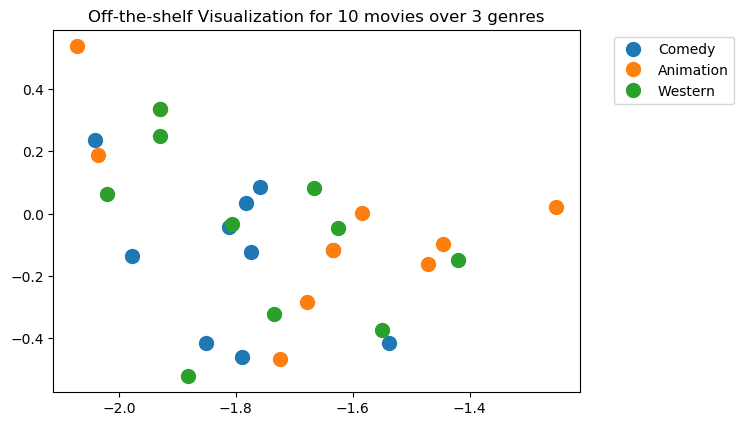

In [14]:
# Find the movie IDs
comedy = []
western = []
animation = []

i = 0
j = 0
k = 0
for item in movies:
    if i == 10 and j == 10 and k == 10:
        break
        
    # Append the movie ID
    if int(item[7]) == 1 and i < 10:
        comedy.append(int(item[0]))
        i += 1
    if int(item[16]) == 1 and j < 10:
        animation.append(int(item[0]))
        j += 1
    if int(item[20]) == 1 and k < 10:
        western.append(int(item[0]))
        k += 1

# Find the values in V_tilda corresponding
# to the movies. Each of the arrays below
# will contain separate arrays that correspond to 
# V_tilda's columns
comedy2 = [[], []]
western2 = [[], []]
animation2 = [[], []]

for element in comedy:
    index = element
    comedy2[0].append(V_tilda[0][index - 1])
    comedy2[1].append(V_tilda[1][index - 1])

for element in western:
    index = element
    western2[0].append(V_tilda[0][index - 1])
    western2[1].append(V_tilda[1][index - 1])

for element in animation:
    index = element
    animation2[0].append(V_tilda[0][index - 1])
    animation2[1].append(V_tilda[1][index - 1])

# Now, plot the values
plt.figure(num=None, figsize=(6.8, 4.8), dpi=100, facecolor='w', edgecolor='k')
plt.plot(comedy2[0], \
         comedy2[1], 'o', markersize=10, label='Comedy')

plt.plot(animation2[0], \
         animation2[1], 'o', markersize=10, label='Animation')

plt.plot(western2[0], \
         western2[1], 'o', markersize=10, label='Western')

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title('Off-the-shelf Visualization for 10 movies over 3 genres')
plt.show()
plt.savefig('graph4.png')

# Extra Exploratory Data Analysis and Visualizations

Here, we look at the trend for all the movies

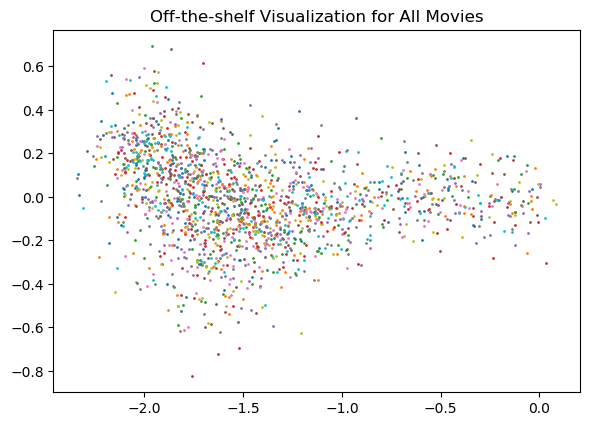

In [15]:
plt.figure(num=None, figsize=(6.8, 4.8), dpi=100, facecolor='w', edgecolor='k')

for element in movies:
    index = int(element[0])
    label = movies[index - 1][1]
    plt.plot(V_tilda[0][index - 1], V_tilda[1][index - 1], 'o', markersize = 1, label = label)

plt.title('Off-the-shelf Visualization for All Movies')
plt.show()

plt.savefig('graph2.png')

Also, we can view the average position by category

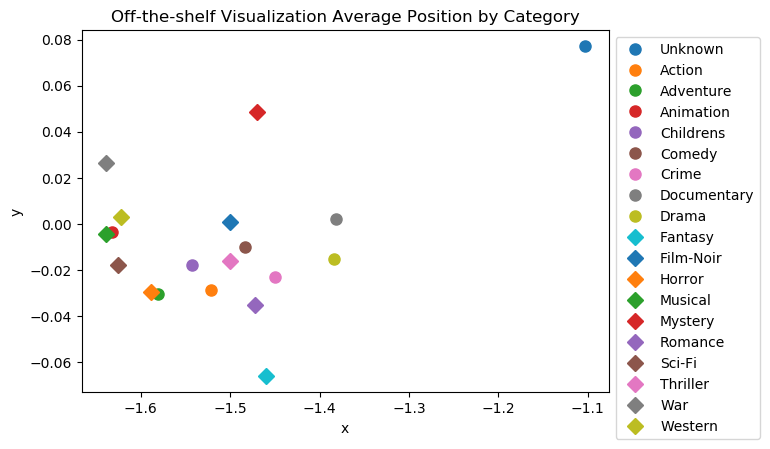

In [16]:
plt.figure(num=None, figsize=(6.8, 4.8), dpi=100, facecolor='w', edgecolor='k')

counts = [0] * (len(movies[0]) - 2)
totals = np.zeros(((len(movies[0]) - 2), 2))

for movie in movies[:]:
    index = int(movie[0]) - 1
    for j in range(len(movie) - 2):
        if movie[j + 2] == '1':
            totals[j][0] += V_tilda[0][index]
            totals[j][1] += V_tilda[1][index]
            counts[j] += 1
categories = ['Unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy',
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

for i in range(int(len(counts) / 2)):
    plt.plot(totals[i][0] / counts[i], totals[i][1] / counts[i], 'o', markersize=8, label=categories[i])
    
for i in range(int(len(counts) / 2), len(counts)):
    plt.plot(totals[i][0] / counts[i], totals[i][1] / counts[i], 'D', markersize=8, label=categories[i])

plt.title('Off-the-shelf Visualization Average Position by Category')
plt.ylabel('y')
plt.xlabel('x')

plt.legend(loc=2, bbox_to_anchor=(1, 1))
plt.show()


Now, we can examine movies by number of categories they fall into

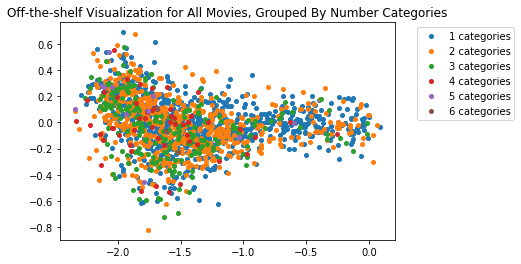

In [17]:
# there are 18 categories excluding unknown

ratings = []
for i in range(18):
    ratings.append([])

for element in movies:
    count = 0
    for i in range(3, 21):
        if int(element[i]) == 1:
            count += 1
    if count > 0:
        ratings[count - 1].append(int(element[0]))

ratings2 = [[[], []], [[], []], [[], []], [[], []], [[], []], [[], []]]
for i in range(6):
    for element in ratings[i]:
        index = element
        ratings2[i][0].append(V_tilda[0][index - 1])
        ratings2[i][1].append(V_tilda[1][index - 1])

for i in range(len(ratings2)):
    label = str(i + 1) + " categories"
    plt.plot(ratings2[i][0], \
             ratings2[i][1], 'o', markersize=4, label=label)
    
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title('Off-the-shelf Visualization for All Movies, Grouped By Number Categories')
plt.show()
plt.show()

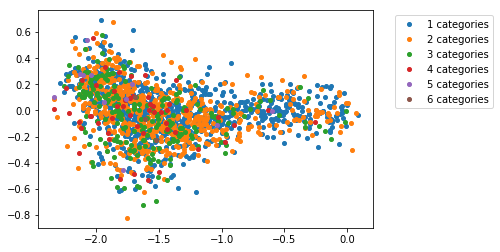

In [18]:
ratings3 = [ratings2[0], ratings2[1], ratings2[2], [[], []]]

for i in range(len(ratings2[3][0])):
    ratings3[3][0].append(ratings2[3][0][i])
    ratings3[3][1].append(ratings2[3][1][i])
    
for i in range(len(ratings2[4][0])):
    ratings3[3][0].append(ratings2[4][0][i])
    ratings3[3][1].append(ratings2[4][1][i])
    
for i in range(len(ratings2[5][0])):
    ratings3[3][0].append(ratings2[5][0][i])
    ratings3[3][1].append(ratings2[5][1][i])
    
for i in range(len(ratings2)):
    label = str(i + 1) + " categories"
    plt.plot(ratings2[i][0], \
             ratings2[i][1], 'o', markersize=4, label=label)
    
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.show()

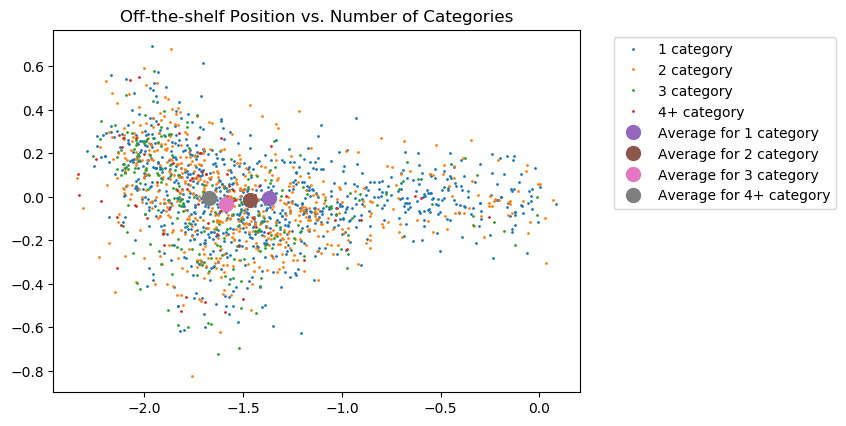

In [19]:
plt.figure(num=None, figsize=(6.8, 4.8), dpi=100, facecolor='w', edgecolor='k')
plt.plot(ratings3[0][0], \
         ratings3[0][1], 'o', markersize=1, label='1 category')

plt.plot(ratings3[1][0], \
         ratings3[1][1], 'o', markersize=1, label='2 category')

plt.plot(ratings3[2][0], \
         ratings3[2][1], 'o', markersize=1, label='3 category')

plt.plot(ratings3[3][0], \
         ratings3[3][1], 'o', markersize=1, label='4+ category')


plt.plot([np.mean(np.array(ratings3[0][0]))], \
         [np.mean(np.array(ratings3[0][1]))], 'o', markersize=10, \
         label='Average for 1 category')

plt.plot([np.mean(np.array(ratings3[1][0]))], \
         [np.mean(np.array(ratings3[1][1]))], 'o', markersize=10, \
         label='Average for 2 category')

plt.plot([np.mean(np.array(ratings3[2][0]))], \
         [np.mean(np.array(ratings3[2][1]))], 'o', markersize=10, \
         label='Average for 3 category')

plt.plot([np.mean(np.array(ratings3[3][0]))], \
         [np.mean(np.array(ratings3[3][1]))], 'o', markersize=10, \
         label='Average for 4+ category')

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title('Off-the-shelf Position vs. Number of Categories')
plt.show()

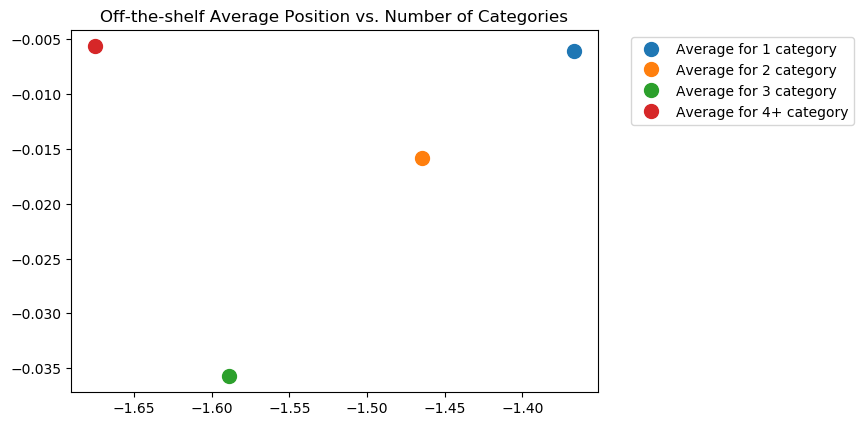

In [20]:
plt.figure(num=None, figsize=(6.8, 4.8), dpi=100, facecolor='w', edgecolor='k')
plt.plot([np.mean(np.array(ratings3[0][0]))], \
         [np.mean(np.array(ratings3[0][1]))], 'o', markersize=10, \
         label='Average for 1 category')

plt.plot([np.mean(np.array(ratings3[1][0]))], \
         [np.mean(np.array(ratings3[1][1]))], 'o', markersize=10, \
         label='Average for 2 category')

plt.plot([np.mean(np.array(ratings3[2][0]))], \
         [np.mean(np.array(ratings3[2][1]))], 'o', markersize=10, \
         label='Average for 3 category')

plt.plot([np.mean(np.array(ratings3[3][0]))], \
         [np.mean(np.array(ratings3[3][1]))], 'o', markersize=10, \
         label='Average for 4+ category')

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title('Off-the-shelf Average Position vs. Number of Categories')
plt.show()